In [1]:
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv('train.csv/train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv('test.csv/test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv('songs.csv/songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv('members.csv/members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv('song_extra_info.csv/song_extra_info.csv')

<font color=red>Merge train with song</font>

In [3]:
train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

<font color=red>convert to unix time</font>

In [4]:
members.registration_init_time = members.registration_init_time.apply(lambda x : time.mktime(x.timetuple()))
members.expiration_date = members.expiration_date.apply(lambda x : time.mktime(x.timetuple()))

In [5]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

In [6]:
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)


<font color=red>Merge another two table</font>

In [7]:
train = train.merge(members, on='msno', how='left')
train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(members, on='msno', how='left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')

<font color=red>Handling NA values</font>

In [8]:
train.song_length.fillna(train.song_length.mean(),inplace=True)
test.song_length.fillna(test.song_length.mean(),inplace=True)

In [9]:
null_cols = ["source_system_tab", "source_screen_name", "source_type", "genre_ids", "artist_name", "composer"
            ,"lyricist", "language", "gender", "song_year"]

In [10]:
def fill_null(df, cols):
    for i in cols:
        df[i].fillna(df[i].mode()[0], inplace=True)

In [11]:
fill_null(train, null_cols)
fill_null(test, null_cols)

In [12]:
from sklearn import preprocessing

In [13]:
le = preprocessing.LabelEncoder()

In [14]:
cat = ['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type','gender','genre_ids','artist_name','composer',
       'lyricist']
def label(df,var):
    for i in var:
        df[i]= le.fit_transform(df[i])

In [15]:
label(train, cat)
label(test, cat)

<font color=red>Valid</font>

In [16]:
X = train.loc[:, train.columns != "target"]
y = train.loc[:, "target"]

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [18]:
# LR = LogisticRegression()

In [19]:
# LR.fit(X_train, y_train)

In [20]:
# LR.score(X_valid, y_valid)

In [33]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

In [34]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [35]:
clf.score(X_valid, y_valid)

0.64653550970393447

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)

In [37]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
rf.score(X_valid, y_valid)

0.68260882530749234

In [39]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()

In [40]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [41]:
ada.score(X_valid, y_valid)

0.63096800778591977

In [18]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier()

In [19]:
bag.fit(X, y)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [20]:
bag.score(X_valid, y_valid)

0.98511729032642847

In [21]:
X_test = test.drop(['id'], axis=1)
ids = test['id'].values
predictions = bag.predict(X_test)

In [23]:
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = predictions
subm.to_csv('lgbm_submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier()

In [46]:
GB.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [47]:
GB.score(X_valid, y_valid)

0.63503663882495509

In [53]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

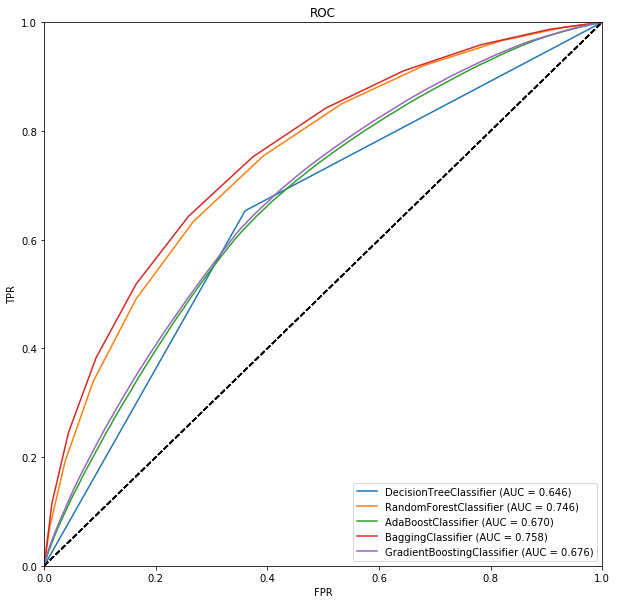

In [54]:
for model in [clf, rf, ada, bag, GB]:
    predict_Y = model.predict_proba(X_valid)[:,1]
    fpr, tpr, thresholds = roc_curve(y_valid, predict_Y)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = str(model).split('(')[0]+ ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")